In [5]:
#minimax

import copy
import sys
import pygame
import random
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt

from constants import *


# Data
labels = []
#numbers = np.array([])

# --- PYGAME SETUP ---

pygame.init()
gam_sound=pygame.mixer.Sound(r"H:\New folder\fourth.1\AI\project\tectactoe\mixkit-game-level-music-689.wav")
screen = pygame.display.set_mode( (WIDTH, HEIGHT) )
pygame.display.set_caption('TIC TAC TOE AI')
screen.fill( BG_COLOR )


             # ----------------Game Instructions-------------------
                   #    ---------press 'g' to change gamemode (pvp or ai)---------
                  # --------- press '0' to change ai level to 0 (random)-----
                    #    ---------press '1' to change ai level to 1 (MINMAX Algorithm)-----
                    #      -----------press 'r' to restart the game ------

# --- CLASSES ---

class Board:

    def __init__(self):
        self.squares = np.zeros( (ROW, COL) )
        self.empty_sqrs = self.squares # [squares]
        self.marked_sqrs = 0

    def final_state(self, show=False):
        # return 0 if no win , return 1 if player 1 is win ,return 2 if palyer 2 is win


        # vertical wins
        for col in range(COL):
            if self.squares[0][col] == self.squares[1][col] == self.squares[2][col] != 0:
                if show:
                    color = CIR_COLOR if self.squares[0][col] == 2 else CROSS_COLOR
                    iPos = (col * SQSIZE + SQSIZE // 2, 20)
                    fPos = (col * SQSIZE + SQSIZE // 2, HEIGHT - 20)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[0][col]

        # horizontal wins
        for row in range(ROW):
            if self.squares[row][0] == self.squares[row][1] == self.squares[row][2] != 0:
                if show:
                    color = CIR_COLOR if self.squares[row][0] == 2 else CROSS_COLOR
                    iPos = (20, row * SQSIZE + SQSIZE // 2)
                    fPos = (WIDTH - 20, row * SQSIZE + SQSIZE // 2)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[row][0]

        # desc diagonal
        if self.squares[0][0] == self.squares[1][1] == self.squares[2][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, 20)
                fPos = (WIDTH - 20, HEIGHT - 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # asc diagonal
        if self.squares[2][0] == self.squares[1][1] == self.squares[0][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, HEIGHT - 20)
                fPos = (WIDTH - 20, 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # no win yet
        return 0

    def mark_sqr(self, row, col, player):
        self.squares[row][col] = player
        self.marked_sqrs += 1

    def empty_sqr(self, row, col):
        return self.squares[row][col] == 0

    def get_empty_sqrs(self):
        empty_sqrs = []
        for row in range(ROW):
            for col in range(COL):
                if self.empty_sqr(row, col):
                    empty_sqrs.append( (row, col) )
        
        return empty_sqrs

    def isfull(self):
        return self.marked_sqrs == 9

    def isempty(self):
        return self.marked_sqrs == 0

class AI:

    def __init__(self, level=1, player=2):
        self.level = level
        self.player = player
        self.nodes_expanded = 0
        #self.nodes_explored = []
    # --- RANDOM ---

    # this fun responsible of know empty square and choose random index to play in it
    def rnd(self, board):
        empty_sqrs = board.get_empty_sqrs()
        idx = random.randrange(0, len(empty_sqrs))

        return empty_sqrs[idx] # return empty square in the postion of index (some row and some colums)

    # --- MINIMAX ---

    def minimax(self, board, maximizing):
        
        # terminal case
        case = board.final_state()

        # player 1 wins
        if case == 1:
            return 1, None # eval, move

        # player 2 wins
        if case == 2:
            return -1, None

        # draw
        elif board.isfull():
            return 0, None

        if maximizing:
            max_eval = -100
            best_move = None
            empty_sqrs = board.get_empty_sqrs()
            
            #nodes_explored = 0

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, 1)
                eval = self.minimax(temp_board, False)[0]
                #nodes_explored += 1
                
                if eval > max_eval:
                    max_eval = eval
                    best_move = (row, col)
                    
            #self.nodes_explored.append(nodes_explored)
            return max_eval, best_move

        elif not maximizing:
            min_eval = 100
            best_move = None
            empty_sqrs = board.get_empty_sqrs()

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, self.player)
                eval = self.minimax(temp_board, True)[0]
                if eval < min_eval:
                    min_eval = eval
                    best_move = (row, col)

            return min_eval, best_move


    # --- MAIN FUNCTION OF AI CLASS  ---
    # this function used to determine if we play with random choice or with minmax algorithm
    def eval(self, main_board):
        # use  rnd function to move in random place which is empty
        if self.level == 0:
            # random choice
            eval = 'random'
            move = self.rnd(main_board)
        else:
            # minmax algorithm choice
            eval, move = self.minimax(main_board, False)

        print(f'AI has chosen to mark the square in pos {move} with an eval of: {eval}')
        return move # row, col

class Game:

    def __init__(self):
        self.board = Board()
        self.ai = AI()
        self.player = 1  #player 1= crosses   # player 2= circles
        self.gamemode = 'ai' # pvp or ai
        self.running = True
        self.show_lines()
       
    # --- DRAW METHODS ---

    def show_lines(self):
        # bg
        screen.fill( BG_COLOR )

        # verticale
        #  line(surface, color, start_pos, end_pos, width=1) -> Rect
        pygame.draw.line(screen, LINE_COLOR, (SQSIZE, 0), (SQSIZE, HEIGHT), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (WIDTH - SQSIZE, 0), (WIDTH - SQSIZE, HEIGHT), LINE_WIDTH)

        # horizontal
        pygame.draw.line(screen, LINE_COLOR, (0, SQSIZE), (WIDTH, SQSIZE), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (0, HEIGHT - SQSIZE), (WIDTH, HEIGHT - SQSIZE), LINE_WIDTH)

    def draw_fig(self, row, col):
        if self.player == 1:
            # draw cross
            # desc line
            start_desc = (col * SQSIZE + OFFSET, row * SQSIZE + OFFSET)
            end_desc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_desc, end_desc, CROSS_WIDTH)
            # asc line
            start_asc = (col * SQSIZE + OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            end_asc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_asc, end_asc, CROSS_WIDTH)
        
        elif self.player == 2:
            # draw circle
            center = (col * SQSIZE + SQSIZE // 2, row * SQSIZE + SQSIZE // 2)
            pygame.draw.circle(screen, CIR_COLOR, center, RADUIS, CIR_WIDTH)

    # --- OTHER METHODS ---

    def make_move(self, row, col):
        self.board.mark_sqr(row, col, self.player)
        self.draw_fig(row, col)
        self.next_turn()

    def next_turn(self):
        self.player = self.player % 2 + 1

    def change_gamemode(self):
        self.gamemode = 'ai' if self.gamemode == 'pvp' else 'pvp'

    def isover(self):
        return self.board.final_state(show=True) != 0 or self.board.isfull()

    def reset(self):
        self.__init__()

def main():

    # --- OBJECTS ---

    game = Game()
    board = game.board
    ai = game.ai

    # --- MAINLOOP ---
    while True:
        
        start_time = time.time()
        
        # pygame events
        for event in pygame.event.get():
            gam_sound.play(-1)
                                    # quit event
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

            # keydown event
            if event.type == pygame.KEYDOWN:

                # g-gamemode
                if event.key == pygame.K_g:
                    game.change_gamemode()

                # r-restart
                if event.key == pygame.K_r:
                    game.reset()
                    board = game.board
                    ai = game.ai

                # 0-random ai
                if event.key == pygame.K_0:
                    ai.level = 0
                
                # 1-random ai
                if event.key == pygame.K_1:
                    ai.level = 1

            # click event
            if event.type == pygame.MOUSEBUTTONDOWN:
                pos = event.pos
                row = pos[1] // SQSIZE
                col = pos[0] // SQSIZE
                
                # human mark sqr
                if board.empty_sqr(row, col) and game.running:
                    game.make_move(row, col)

                    if game.isover():
                        game.running = False


        # AI initial call
        if game.gamemode == 'ai' and game.player == ai.player and game.running:

            # update the screen  to use AI'functions
            pygame.display.update()
            
            ai_start_time = time.time()

            # eval
            # ai methods calling
            row, col = ai.eval(board)
            game.make_move(row, col)

            if game.isover():
                game.running = False
                process = psutil.Process()
                memory_info = process.memory_info()
                rss = memory_info.rss  # resident set size (memory used by the process)
                print(f"Memory used by process: {rss / 1024 ** 2:.2f} MB")
                
            ai_end_time = time.time() 
            ai_execution_time = ai_end_time - ai_start_time
            print(f"AI's turn execution time: {ai_execution_time} seconds")
            print(f"Nodes Expanded: {ai.nodes_expanded}")
            labels.append(ai.nodes_expanded)
        
            
        pygame.display.update()
    print(ai.nodes_expanded)


main()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
AI has chosen to mark the square in pos (0, 0) with an eval of: 0
AI's turn execution time: 1.7319951057434082 seconds
Nodes Expanded: 55504
AI has chosen to mark the square in pos (0, 1) with an eval of: 0
AI's turn execution time: 0.02298593521118164 seconds
Nodes Expanded: 56334
AI has chosen to mark the square in pos (2, 0) with an eval of: 0
AI's turn execution time: 0.003998279571533203 seconds
Nodes Expanded: 56382
AI has chosen to mark the square in pos (1, 2) with an eval of: 0
AI's turn execution time: 0.0010006427764892578 seconds
Nodes Expanded: 56386
AI has chosen to mark the square in pos (1, 1) with an eval of: 0
AI's turn execution time: 2.379340410232544 seconds
Nodes Expanded: 59704
AI has chosen to mark the square in pos (2, 0) with an eval of: 0
AI's turn execution time: 0.027978897094726562 seconds
Nodes Expanded: 60638
AI has chosen to mark the square i

SystemExit: 

C:\Users\M\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:

#alph-beta

import copy
import os
import sys
# import pygame
import random
import numpy as np
import psutil
# import time
from constants import *

alpha = []

# --- PYGAME SETUP ---

pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('TIC TAC TOE AI')
screen.fill(BG_COLOR)

# ----------------Game Instructions-------------------
# ---------press 'g' to change gamemode (pvp or ai)---------
# --------- press '0' to change ai level to 0 (random)-----
# ---------press '1' to change ai level to 1 (MINMAX Algorithm)-----
# ---------press '2' to change ai level to 2 (ALPHA-BETA Algorithm)-----
# -----------press 'r' to restart the game ------

# --- CLASSES ---

class Board:

    def __init__(self):
        self.squares = np.zeros((ROW, COL))
        self.empty_sqrs = self.squares  # [squares]
        self.marked_sqrs = 0

    def final_state(self, show=False):
        # return 0 if no win, return 1 if player 1 is win, return 2 if player 2 is win

        # vertical wins
        for col in range(COL):
            if self.squares[0][col] == self.squares[1][col] == self.squares[2][col] != 0:
                if show:
                    color = CIR_COLOR if self.squares[0][col] == 2 else CROSS_COLOR
                    iPos = (col * SQSIZE + SQSIZE // 2, 20)
                    fPos = (col * SQSIZE + SQSIZE // 2, HEIGHT - 20)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[0][col]

        # horizontal wins
        for row in range(ROW):
            if self.squares[row][0] == self.squares[row][1] == self.squares[row][2] != 0:
                if show:
                    color = CIR_COLOR if self.squares[row][0] == 2 else CROSS_COLOR
                    iPos = (20, row * SQSIZE + SQSIZE // 2)
                    fPos = (WIDTH - 20, row * SQSIZE + SQSIZE // 2)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[row][0]

        # desc diagonal
        if self.squares[0][0] == self.squares[1][1] == self.squares[2][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, 20)
                fPos = (WIDTH - 20, HEIGHT - 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # asc diagonal
        if self.squares[2][0] == self.squares[1][1] == self.squares[0][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, HEIGHT - 20)
                fPos = (WIDTH - 20, 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # no win yet
        return 0

    def mark_sqr(self, row, col, player):
        self.squares[row][col] = player
        self.marked_sqrs += 1

    def empty_sqr(self, row, col):
        return self.squares[row][col] == 0

    def get_empty_sqrs(self):
        empty_sqrs = []
        for row in range(ROW):
            for col in range(COL):
                if self.empty_sqr(row, col):
                    empty_sqrs.append((row, col))

        return empty_sqrs

    def isfull(self):
        return self.marked_sqrs == 9

    def isempty(self):
        return self.marked_sqrs == 0

class AI:

    def __init__(self, level=1, player=2):
        self.level = level
        self.player = player
        self.nodes_expanded = 0

    # --- RANDOM ---

    # this function is responsible for knowing an empty square and choosing a random index to play in it
    def rnd(self, board):
        empty_sqrs = board.get_empty_sqrs()
        idx = random.randrange(0, len(empty_sqrs))

        return empty_sqrs[idx]  # return an empty square in the position of index (some row and some columns)

    # --- MINIMAX with ALPHA-BETA PRUNING ---

    def minimax_alpha_beta(self, board, maximizing, alpha, beta):
        # terminal case
        case = board.final_state()

        # player 1 wins
        if case == 1:
            return 1, None  # eval, move

        # player 2 wins
        if case == 2:
            return -1, None

        # draw
        elif board.isfull():
            return 0, None

        if maximizing:
            max_eval = -100
            best_move = None
            empty_sqrs = board.get_empty_sqrs()

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, 1)
                eval = self.minimax_alpha_beta(temp_board, False, alpha, beta)[0]
                if eval > max_eval:
                    max_eval = eval
                    best_move = (row, col)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break

            return max_eval, best_move

        elif not maximizing:
            min_eval = 100
            best_move = None
            empty_sqrs = board.get_empty_sqrs()
            self.nodes_expanded += 1

            for (row, col) in empty_sqrs:
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, self.player)
                eval = self.minimax_alpha_beta(temp_board, True, alpha, beta)[0]
                if eval < min_eval:
                    min_eval = eval
                    best_move = (row, col)
                beta = min(beta, eval)
                if beta <= alpha:
                    break

            return min_eval, best_move

    # --- MAIN FUNCTION OF AI CLASS  ---

    # this function is used to determine if we play with a random choice or with the minimax algorithm
    def eval(self, main_board):
        # use the rnd function to move to a random place that is empty
        if self.level == 0:
            # random choice
            eval = 'random'
            move = self.rnd(main_board)
        else:
            # minimax algorithm choice with alpha-beta pruning
            eval, move = self.minimax_alpha_beta(main_board, False, -float('inf'), float('inf'))

        print(f'AI has chosen to mark the square in pos {move} with an eval of: {eval}')
        return move  # row, col

# Game class
class Game:
    def __init__(self):
        self.board = Board()
        self.ai = AI()
        self.player = 1
        self.gamemode = 'ai'
        self.running = True
        self.show_lines()

    def make_move(self, row, col):
        self.board.mark_sqr(row, col, self.player)
        self.draw_fig(row, col)
        self.next_turn()

    def next_turn(self):
        self.player = self.player % 2 + 1

    def change_gamemode(self):
        self.gamemode = 'ai' if self.gamemode == 'pvp' else 'pvp'

    def isover(self):
        return self.board.final_state(show=True) != 0 or self.board.isfull()

    def reset(self):
        self.__init__()

    def draw_fig(self, row, col):
        if self.player == 1:
            # draw cross
            # desc line
            start_desc = (col * SQSIZE + OFFSET, row * SQSIZE + OFFSET)
            end_desc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_desc, end_desc, CROSS_WIDTH)
            # asc line
            start_asc = (col * SQSIZE + OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            end_asc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_asc, end_asc, CROSS_WIDTH)

        elif self.player == 2:
            # draw circle
            center = (col * SQSIZE + SQSIZE // 2, row * SQSIZE + SQSIZE // 2)
            pygame.draw.circle(screen, CIR_COLOR, center, RADUIS, CIR_WIDTH)

    def show_lines(self):
        # bg
        screen.fill(BG_COLOR)

        # vertical
        pygame.draw.line(screen, LINE_COLOR, (SQSIZE, 0), (SQSIZE, HEIGHT), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (WIDTH - SQSIZE, 0), (WIDTH - SQSIZE, HEIGHT), LINE_WIDTH)

        # horizontal
        pygame.draw.line(screen, LINE_COLOR, (0, SQSIZE), (WIDTH, SQSIZE), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (0, HEIGHT - SQSIZE), (WIDTH, HEIGHT - SQSIZE), LINE_WIDTH)

# ... (the rest of your main function code)
import time

def main():
    total_nodes_expanded = 0
    total_time_elapsed = 0
    total_memory_used = 0

    num_rounds = 5  # Change this to the desired number of rounds

    for _ in range(num_rounds):
        # --- OBJECTS ---
        game = Game()
        board = game.board
        ai = game.ai

        # --- GAME LOOP ---
        start_time = time.time()
        while not game.isover():
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()

                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_g:
                        game.change_gamemode()

                    if event.key == pygame.K_r:
                        game.reset()
                        board = game.board
                        ai = game.ai

                    if event.key == pygame.K_0:
                        ai.level = 0

                    if event.key == pygame.K_1:
                        ai.level = 1

                    if event.key == pygame.K_2:
                        ai.level = 2

                if event.type == pygame.MOUSEBUTTONDOWN:
                    pos = event.pos
                    row = pos[1] // SQSIZE
                    col = pos[0] // SQSIZE

                    if board.empty_sqr(row, col) and game.running:
                        game.make_move(row, col)

                        if game.isover():
                            game.running = False

            if game.gamemode == 'ai' and game.player == ai.player and game.running:
                row, col = game.ai.eval(game.board)
                game.make_move(row, col)

                if game.isover():
                    game.running = False

                print(f"Nodes Expanded: {ai.nodes_expanded}")
                alpha.append(ai.nodes_expanded)

            pygame.display.update()
        start_time = time.time()

        # Simulate some time-consuming operations
        for _ in range(1000000):
            _ = 2 * 2

        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Elapsed Time: {elapsed_time} seconds")
        memory_used = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # in MB
        print(f"memory_used:{memory_used}")

        # Accumulate values for averaging
        total_nodes_expanded += ai.nodes_expanded
        total_time_elapsed += elapsed_time
        total_memory_used += memory_used

        # Display result for this round
        print("Game Over!")
        winner = game.board.final_state(show=True)
        if winner == 1:
            print("Player 1 wins!")
        elif winner == 2:
            print("Player 2 (or AI) wins!")
        else:
            print("It's a draw!")

        # Reset nodes_expanded for the next round
        ai.nodes_expanded = 0

    # Calculate averages
    avg_nodes_expanded = total_nodes_expanded / num_rounds
    avg_time_elapsed = total_time_elapsed / num_rounds
    avg_memory_used = total_memory_used / num_rounds

    print(f"\nAverage Nodes Expanded: {avg_nodes_expanded}")
    print(f"Average Time Elapsed: {avg_time_elapsed} seconds")
    print(f"Average Memory Used: {avg_memory_used} MB")
   

    pygame.quit()
    sys.exit()

main()


AI has chosen to mark the square in pos (0, 0) with an eval of: 0
Nodes Expanded: 1705
AI has chosen to mark the square in pos (2, 0) with an eval of: 0
Nodes Expanded: 1879
AI has chosen to mark the square in pos (1, 2) with an eval of: 0
Nodes Expanded: 1905
AI has chosen to mark the square in pos (2, 1) with an eval of: 0
Nodes Expanded: 1908
Elapsed Time: 0.06096172332763672 seconds
memory_used:147.73828125
Game Over!
It's a draw!
AI has chosen to mark the square in pos (0, 0) with an eval of: 0
Nodes Expanded: 1705
AI has chosen to mark the square in pos (1, 0) with an eval of: 0
Nodes Expanded: 1829
AI has chosen to mark the square in pos (2, 0) with an eval of: -1
Nodes Expanded: 1840
Elapsed Time: 0.10193777084350586 seconds
memory_used:147.73828125
Game Over!
Player 2 (or AI) wins!


SystemExit: 

In [7]:
#distance

import copy
import sys
import time
import pygame
import numpy as np
import psutil

distance = []

# Constants
WIDTH, HEIGHT = 600, 600
SQSIZE = WIDTH // 3
ROW, COL = 3, 3
OFFSET = 15
LINE_WIDTH = 15
CROSS_WIDTH = 25
CIR_WIDTH = 15
RADUIS = SQSIZE // 3

BG_COLOR = (255, 255, 255)
LINE_COLOR = (0, 0, 0)
CROSS_COLOR = (255, 0, 0)
CIR_COLOR = (0, 0, 255)

WINNING_LINES = [
    (0, 1, 2), (3, 4, 5), (6, 7, 8),  # Rows
    (0, 3, 6), (1, 4, 7), (2, 5, 8),  # Columns
    (0, 4, 8), (2, 4, 6)  # Diagonals
]

# Pygame setup
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('TIC TAC TOE AI')
screen.fill(BG_COLOR)

# Classes
class Board:
    def __init__(self):
        self.squares = np.zeros((ROW, COL))
        self.empty_sqrs = self.squares
        self.marked_sqrs = 0
        self.player = 1

    def final_state(self, show=False):
        # return 0 if no win , return 1 if player 1 is win ,return 2 if palyer 2 is win


        # vertical wins
        for col in range(COL):
            if self.squares[0][col] == self.squares[1][col] == self.squares[2][col] != 0:
                if show:
                    color = CIR_COLOR if self.squares[0][col] == 2 else CROSS_COLOR
                    iPos = (col * SQSIZE + SQSIZE // 2, 20)
                    fPos = (col * SQSIZE + SQSIZE // 2, HEIGHT - 20)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[0][col]

        # horizontal wins
        for row in range(ROW):
            if self.squares[row][0] == self.squares[row][1] == self.squares[row][2] != 0:
                if show:
                    color = CIR_COLOR if self.squares[row][0] == 2 else CROSS_COLOR
                    iPos = (20, row * SQSIZE + SQSIZE // 2)
                    fPos = (WIDTH - 20, row * SQSIZE + SQSIZE // 2)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[row][0]

        # desc diagonal
        if self.squares[0][0] == self.squares[1][1] == self.squares[2][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, 20)
                fPos = (WIDTH - 20, HEIGHT - 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # asc diagonal
        if self.squares[2][0] == self.squares[1][1] == self.squares[0][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, HEIGHT - 20)
                fPos = (WIDTH - 20, 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # no win yet
        return 0

    def mark_sqr(self, row, col, player):
        self.squares[row][col] = player
        self.marked_sqrs += 1

    def empty_sqr(self, row, col):
        return self.squares[row][col] == 0

    def get_empty_sqrs(self):
        empty_sqrs = []
        for row in range(ROW):
            for col in range(COL):
                if self.empty_sqr(row, col):
                    empty_sqrs.append((row, col))
        return empty_sqrs

    def isfull(self):
        return self.marked_sqrs == 9
    
    def isempty(self):
        return self.marked_sqrs == 0

class AI:
    def __init__(self, level=1, player=2):
        self.level = level
        self.player = player
        self.nodes_expanded = 0

    def minimax_heuristic(self, board, maximizing, depth=0, alpha=float('-inf'), beta=float('inf')):
        case = board.final_state()

        if case == 1:
            return 10 - depth, None
        elif case == 2:
            return depth - 10, None
        elif board.isfull():
            return 0, None

        if maximizing:
            max_eval = float('-inf')
            best_move = None
            empty_sqrs = board.get_empty_sqrs()

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, 1)
                eval, _ = self.minimax_heuristic(temp_board, False, depth + 1, alpha, beta)
                distance = self.distance_heuristic(row, col)
                eval += distance
                if eval > max_eval:
                    max_eval = eval
                    best_move = (row, col)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break

            return max_eval, best_move

        elif not maximizing:
            min_eval = float('inf')
            best_move = None
            empty_sqrs = board.get_empty_sqrs()

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, self.player)
                eval, _ = self.minimax_heuristic(temp_board, True, depth + 1, alpha, beta)
                distance = self.distance_heuristic(row, col)
                eval -= distance
                if eval < min_eval:
                    min_eval = eval
                    best_move = (row, col)
                beta = min(beta, eval)
                if beta <= alpha:
                    break

            return min_eval, best_move

    def distance_heuristic(self, row, col):
        center_row, center_col = ROW // 2, COL // 2
        return abs(row - center_row) + abs(col - center_col)

    def eval(self, main_board):
        if self.level == 0:
            eval = 'random'
            move = self.rnd(main_board)
        else:
            eval, move = self.minimax_heuristic(main_board, False, alpha=float('-inf'), beta=float('inf'))

        if move is not None:
            row, col = move
            distance = self.distance_heuristic(row, col)
            print(f'AI has chosen to mark the square in pos {move} with an eval of: {eval} and distance: {distance}')

        return move

    def rnd(self, board):
        empty_sqrs = board.get_empty_sqrs()
        idx = np.random.choice(len(empty_sqrs))
        return empty_sqrs[idx]

class Game:
    def __init__(self):
        self.board = Board()
        self.ai = AI()
        self.player = 1
        self.running = True
        self.show_lines()

    def show_lines(self):
        screen.fill(BG_COLOR)

        pygame.draw.line(screen, LINE_COLOR, (SQSIZE, 0), (SQSIZE, HEIGHT), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (WIDTH - SQSIZE, 0), (WIDTH - SQSIZE, HEIGHT), LINE_WIDTH)

        pygame.draw.line(screen, LINE_COLOR, (0, SQSIZE), (WIDTH, SQSIZE), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (0, HEIGHT - SQSIZE), (WIDTH, HEIGHT - SQSIZE), LINE_WIDTH)

    def draw_fig(self, row, col):
        if self.player == 1:
            start_desc = (col * SQSIZE + OFFSET, row * SQSIZE + OFFSET)
            end_desc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_desc, end_desc, CROSS_WIDTH)
            start_asc = (col * SQSIZE + OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            end_asc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_asc, end_asc, CROSS_WIDTH)

        elif self.player == 2:
            center = (col * SQSIZE + SQSIZE // 2, row * SQSIZE + SQSIZE // 2)
            pygame.draw.circle(screen, CIR_COLOR, center, RADUIS, CIR_WIDTH)

    def make_move(self, row, col):
        self.board.mark_sqr(row, col, self.player)
        self.draw_fig(row, col)
        self.next_turn()

    def next_turn(self):
        self.player = self.player % 2 + 1
    
    def change_gamemode(self):
        self.gamemode = 'ai' if self.gamemode == 'pvp' else 'pvp'

    def isover(self):
        return self.board.final_state(show=True) != 0 or self.board.isfull()

    def reset(self):
        self.__init__()

def main():
    game = Game()
    board = game.board
    ai = game.ai

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
            if event.type == pygame.KEYDOWN:

                # g-gamemode
                if event.key == pygame.K_g:
                    game.change_gamemode()

                # r-restart
                if event.key == pygame.K_r:
                    game.reset()
                    board = game.board
                    ai = game.ai

                # 0-random ai
                if event.key == pygame.K_0:
                    ai.level = 0
                
                # 1-random ai
                if event.key == pygame.K_1:
                    ai.level = 1
            
            if event.type == pygame.MOUSEBUTTONDOWN:
                pos = event.pos
                row = pos[1] // SQSIZE
                col = pos[0] // SQSIZE
                if game.board.empty_sqr(row, col) and game.running:
                    game.make_move(row, col)
                    if game.isover():
                        game.running = False

        if game.player == game.ai.player and game.running:
            row, col = game.ai.eval(game.board)
            game.make_move(row, col)

            if game.isover():
                game.running = False
                process = psutil.Process()
                memory_info = process.memory_info()
                rss = memory_info.rss
                print(f"Memory used by process: {rss / 1024 ** 2:.2f} MB")

            print(f"Nodes Expanded: {game.ai.nodes_expanded}")
            distance.append(game.ai.nodes_expanded)

        pygame.display.update()

if __name__ == "__main__":
    main()


AI has chosen to mark the square in pos (0, 0) with an eval of: 0 and distance: 2
Nodes Expanded: 2303
AI has chosen to mark the square in pos (2, 0) with an eval of: 0 and distance: 2
Nodes Expanded: 2575
AI has chosen to mark the square in pos (1, 2) with an eval of: 1 and distance: 1
Nodes Expanded: 2607
AI has chosen to mark the square in pos (2, 1) with an eval of: 1 and distance: 1
Nodes Expanded: 2611
AI has chosen to mark the square in pos (0, 0) with an eval of: 0 and distance: 2
Nodes Expanded: 2303
AI has chosen to mark the square in pos (2, 0) with an eval of: 0 and distance: 2
Nodes Expanded: 2575
AI has chosen to mark the square in pos (1, 2) with an eval of: 1 and distance: 1
Nodes Expanded: 2607
AI has chosen to mark the square in pos (2, 1) with an eval of: 1 and distance: 1
Nodes Expanded: 2611


SystemExit: 

In [8]:
#evolution

import copy
import sys
import time
import psutil
import pygame
import random
import numpy as np

evo = []

# Constants
WIDTH, HEIGHT = 600, 600
SQSIZE = WIDTH // 3
ROW, COL = 3, 3
OFFSET = 15
LINE_WIDTH = 15
CROSS_WIDTH = 25
CIR_WIDTH = 15
RADUIS = SQSIZE // 3

BG_COLOR = (255, 255, 255)
LINE_COLOR = (0, 0, 0)
CROSS_COLOR = (255, 0, 0)
CIR_COLOR = (0, 0, 255)

WINNING_LINES = [
    (0, 1, 2), (3, 4, 5), (6, 7, 8),  # Rows
    (0, 3, 6), (1, 4, 7), (2, 5, 8),  # Columns
    (0, 4, 8), (2, 4, 6)  # Diagonals
]

# --- PYGAME SETUP ---
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('TIC TAC TOE AI')
screen.fill(BG_COLOR)

# --- CLASSES ---
class Board:
    def __init__(self):
        self.squares = np.zeros((ROW, COL))
        self.empty_sqrs = self.squares
        self.marked_sqrs = 0
        self.player = 1

    def final_state(self, show=False):
        # return 0 if no win , return 1 if player 1 is win ,return 2 if palyer 2 is win


        # vertical wins
        for col in range(COL):
            if self.squares[0][col] == self.squares[1][col] == self.squares[2][col] != 0:
                if show:
                    color = CIR_COLOR if self.squares[0][col] == 2 else CROSS_COLOR
                    iPos = (col * SQSIZE + SQSIZE // 2, 20)
                    fPos = (col * SQSIZE + SQSIZE // 2, HEIGHT - 20)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[0][col]

        # horizontal wins
        for row in range(ROW):
            if self.squares[row][0] == self.squares[row][1] == self.squares[row][2] != 0:
                if show:
                    color = CIR_COLOR if self.squares[row][0] == 2 else CROSS_COLOR
                    iPos = (20, row * SQSIZE + SQSIZE // 2)
                    fPos = (WIDTH - 20, row * SQSIZE + SQSIZE // 2)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[row][0]

        # desc diagonal
        if self.squares[0][0] == self.squares[1][1] == self.squares[2][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, 20)
                fPos = (WIDTH - 20, HEIGHT - 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # asc diagonal
        if self.squares[2][0] == self.squares[1][1] == self.squares[0][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, HEIGHT - 20)
                fPos = (WIDTH - 20, 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # no win yet
        return 0

    def mark_sqr(self, row, col, player):
        self.squares[row][col] = player
        self.marked_sqrs += 1

    def empty_sqr(self, row, col):
        return self.squares[row][col] == 0

    def get_empty_sqrs(self):
        empty_sqrs = []
        for row in range(ROW):
            for col in range(COL):
                if self.empty_sqr(row, col):
                    empty_sqrs.append((row, col))
        return empty_sqrs

    def isfull(self):
        return self.marked_sqrs == 9
    
    def isempty(self):
        return self.marked_sqrs == 0

class AI:
    def __init__(self, level=1, player=2):
        self.level = level
        self.player = player
        self.nodes_expanded = 0

    def rnd(self, board):
        empty_sqrs = board.get_empty_sqrs()
        idx = random.randrange(0, len(empty_sqrs))
        return empty_sqrs[idx]

    def minimax(self, board, maximizing, alpha, beta):
        case = board.final_state()

        if case == 1:
            return 1, None
        elif case == 2:
            return -1, None
        elif board.isfull():
            return 0, None

        if maximizing:
            max_eval = -100
            best_move = None
            empty_sqrs = board.get_empty_sqrs()

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, 1)
                eval = self.minimax(temp_board, False, alpha, beta)[0]
                if eval > max_eval:
                    max_eval = eval
                    best_move = (row, col)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break

            return max_eval, best_move

        elif not maximizing:
            min_eval = 100
            best_move = None
            empty_sqrs = board.get_empty_sqrs()

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, self.player)
                eval = self.minimax(temp_board, True, alpha, beta)[0]
                if eval < min_eval:
                    min_eval = eval
                    best_move = (row, col)
                beta = min(beta, eval)
                if beta <= alpha:
                    break

            return min_eval, best_move

    def blocking_opponent_evaluation(self, board, row, col):
        opponent = 1 if self.player == 2 else 2
        opponent_lines = sum(1 for line in WINNING_LINES if
                            board.squares.flatten()[line[0]] == opponent and
                            board.squares.flatten()[line[1]] == opponent and
                            board.squares.flatten()[line[2]] == 0)
        return -opponent_lines

    def enhanced_heuristic_evaluation(self, board, row, col):
        temp_board = copy.deepcopy(board)
        temp_board.mark_sqr(row, col, self.player)

        # Check if the move results in a win
        if temp_board.final_state() == self.player:
            return 10  # A winning move is highly favorable

        # Check if the move blocks the opponent from winning
        opponent = 1 if self.player == 2 else 2
        temp_board.mark_sqr(row, col, opponent)
        if temp_board.final_state() == opponent:
            return 9  # Blocking opponent's winning move is also favorable

        # Apply your existing blocking_opponent_evaluation heuristic
        opponent_lines = self.blocking_opponent_evaluation(board, row, col)

        # Add some randomness to the evaluation to make moves less predictable
        random_bonus = random.uniform(0, 1) * 3

        return opponent_lines + random_bonus

    def heuristic_evaluation(self, board, row, col):
        if self.level == 0:
            eval = 'random'
            move = self.rnd(board)
        elif self.level == 1:
            eval, move = self.minimax(board, False, float('-inf'), float('inf'))
        else:
            eval = self.enhanced_heuristic_evaluation(board, row, col)
            move = (row, col)

        print(f'AI has chosen to mark the square in pos {move} with an eval of: {eval}')
        return move

    def eval(self, main_board):
        if self.level == 0:
            eval = 'random'
            move = self.rnd(main_board)
        elif self.level == 1:
            eval, move = self.minimax(main_board, False, float('-inf'), float('inf'))
        else:
            empty_sqrs = main_board.get_empty_sqrs()
            moves = [(row, col) for (row, col) in empty_sqrs]
            moves_evaluations = [self.enhanced_heuristic_evaluation(main_board, row, col) for (row, col) in moves]
            best_move = moves[np.argmax(moves_evaluations)]
            move = best_move
            eval = self.enhanced_heuristic_evaluation(main_board, move[0], move[1])

        print(f'AI has chosen to mark the square in pos {move} with an eval of: {eval}')
        return move

class Game:
    def __init__(self):
        self.board = Board()
        self.ai = AI()
        self.player = 1
        self.running = True
        self.show_lines()
        self.gamemode = 'ai'

    def show_lines(self):
        screen.fill(BG_COLOR)

        pygame.draw.line(screen, LINE_COLOR, (SQSIZE, 0), (SQSIZE, HEIGHT), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (WIDTH - SQSIZE, 0), (WIDTH - SQSIZE, HEIGHT), LINE_WIDTH)

        pygame.draw.line(screen, LINE_COLOR, (0, SQSIZE), (WIDTH, SQSIZE), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (0, HEIGHT - SQSIZE), (WIDTH, HEIGHT - SQSIZE), LINE_WIDTH)

    def draw_fig(self, row, col):
        if self.player == 1:
            start_desc = (col * SQSIZE + OFFSET, row * SQSIZE + OFFSET)
            end_desc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_desc, end_desc, CROSS_WIDTH)
            start_asc = (col * SQSIZE + OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            end_asc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_asc, end_asc, CROSS_WIDTH)

        elif self.player == 2:
            center = (col * SQSIZE + SQSIZE // 2, row * SQSIZE + SQSIZE // 2)
            pygame.draw.circle(screen, CIR_COLOR, center, RADUIS, CIR_WIDTH)

    def make_move(self, row, col):
        self.board.mark_sqr(row, col, self.player)
        self.draw_fig(row, col)
        self.next_turn()

        if self.isover() and self.running:
            player_lines = self.count_winning_lines()
            self.print_winning_lines(player_lines)

    def next_turn(self):
        self.player = self.player % 2 + 1
        
    def change_gamemode(self):
        self.gamemode = 'ai' if self.gamemode == 'pvp' else 'pvp'

    def isover(self):
        return self.board.final_state(show=True) != 0 or self.board.isfull()

    def reset(self):
        self.__init__()

    def count_winning_lines(self):
        player_lines = {1: 0, 2: 0}
        for line in WINNING_LINES:
            if all(self.board.squares.flatten()[i] == 1 for i in line):
                player_lines[1] += 1
            elif all(self.board.squares.flatten()[i] == 2 for i in line):
                player_lines[2] += 1
        return player_lines

    def print_winning_lines(self, player_lines):
        for player, count in player_lines.items():
            print(f"Player {player} has {count} winning lines.")

def main():
    game = Game()
    board = game.board
    ai = game.ai

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
                
             # keydown event
            if event.type == pygame.KEYDOWN:

                # g-gamemode
                if event.key == pygame.K_g:
                    game.change_gamemode()

                # r-restart
                if event.key == pygame.K_r:
                    game.reset()
                    board = game.board
                    ai = game.ai

                # 0-random ai
                if event.key == pygame.K_0:
                    ai.level = 0
                
                # 1-random ai
                if event.key == pygame.K_1:
                    ai.level = 1


            if event.type == pygame.MOUSEBUTTONDOWN:
                pos = event.pos
                row = pos[1] // SQSIZE
                col = pos[0] // SQSIZE

                if board.empty_sqr(row, col) and game.running:
                    game.make_move(row, col)

                    if game.isover():
                        game.running = False
                        player_lines = game.count_winning_lines()
                        game.print_winning_lines(player_lines)

        if game.player == ai.player and game.running:
            pygame.display.update()

            row, col = ai.eval(board)
            game.make_move(row, col)

            if game.isover():
                game.running = False
                process = psutil.Process()
                memory_info = process.memory_info()
                rss = memory_info.rss  # resident set size (memory used by the process)
                print(f"Memory used by process: {rss / 1024 ** 2:.2f} MB")

            print(f"Nodes Expanded: {ai.nodes_expanded}")
            evo.append(ai.nodes_expanded)

        pygame.display.update()

main()


AI has chosen to mark the square in pos (0, 0) with an eval of: 0
Nodes Expanded: 2315
AI has chosen to mark the square in pos (2, 0) with an eval of: 0
Nodes Expanded: 2544
AI has chosen to mark the square in pos (1, 2) with an eval of: 0
Nodes Expanded: 2576
AI has chosen to mark the square in pos (2, 1) with an eval of: 0
Nodes Expanded: 2580
Player 1 has 0 winning lines.
Player 2 has 0 winning lines.
Player 1 has 0 winning lines.
Player 2 has 0 winning lines.
AI has chosen to mark the square in pos (0, 2) with an eval of: 0
Nodes Expanded: 3589
AI has chosen to mark the square in pos (1, 0) with an eval of: 0
Nodes Expanded: 3797
AI has chosen to mark the square in pos (2, 1) with an eval of: 0
Nodes Expanded: 3830
AI has chosen to mark the square in pos (0, 0) with an eval of: 0
Nodes Expanded: 3834
Player 1 has 0 winning lines.
Player 2 has 0 winning lines.
Player 1 has 0 winning lines.
Player 2 has 0 winning lines.


SystemExit: 

In [9]:
#symmetry

import copy
import os
import sys
# import pygame
import random
import numpy as np
import psutil
# import time
from constants import *

sym = []

# --- PYGAME SETUP ---

pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('TIC TAC TOE AI')
screen.fill(BG_COLOR)

# ----------------Game Instructions-------------------
# ---------press 'g' to change gamemode (pvp or ai)---------
# --------- press '0' to change ai level to 0 (random)-----
# ---------press '1' to change ai level to 1 (MINMAX Algorithm)-----
# ---------press '2' to change ai level to 2 (ALPHA-BETA Algorithm)-----
# -----------press 'r' to restart the game ------

# --- CLASSES ---

class Board:

    def __init__(self):
        self.squares = np.zeros((ROW, COL))
        self.empty_sqrs = self.squares  # [squares]
        self.marked_sqrs = 0

    def final_state(self, show=False):
        # return 0 if no win, return 1 if player 1 is win, return 2 if player 2 is win

        # vertical wins
        for col in range(COL):
            if self.squares[0][col] == self.squares[1][col] == self.squares[2][col] != 0:
                if show:
                    color = CIR_COLOR if self.squares[0][col] == 2 else CROSS_COLOR
                    iPos = (col * SQSIZE + SQSIZE // 2, 20)
                    fPos = (col * SQSIZE + SQSIZE // 2, HEIGHT - 20)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[0][col]

        # horizontal wins
        for row in range(ROW):
            if self.squares[row][0] == self.squares[row][1] == self.squares[row][2] != 0:
                if show:
                    color = CIR_COLOR if self.squares[row][0] == 2 else CROSS_COLOR
                    iPos = (20, row * SQSIZE + SQSIZE // 2)
                    fPos = (WIDTH - 20, row * SQSIZE + SQSIZE // 2)
                    pygame.draw.line(screen, color, iPos, fPos, LINE_WIDTH)
                return self.squares[row][0]

        # desc diagonal
        if self.squares[0][0] == self.squares[1][1] == self.squares[2][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, 20)
                fPos = (WIDTH - 20, HEIGHT - 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # asc diagonal
        if self.squares[2][0] == self.squares[1][1] == self.squares[0][2] != 0:
            if show:
                color = CIR_COLOR if self.squares[1][1] == 2 else CROSS_COLOR
                iPos = (20, HEIGHT - 20)
                fPos = (WIDTH - 20, 20)
                pygame.draw.line(screen, color, iPos, fPos, CROSS_WIDTH)
            return self.squares[1][1]

        # no win yet
        return 0

    def mark_sqr(self, row, col, player):
        self.squares[row][col] = player
        self.marked_sqrs += 1

    def empty_sqr(self, row, col):
        return self.squares[row][col] == 0

    def get_empty_sqrs(self):
        empty_sqrs = []
        for row in range(ROW):
            for col in range(COL):
                if self.empty_sqr(row, col):
                    empty_sqrs.append((row, col))

        return empty_sqrs

    def isfull(self):
        return self.marked_sqrs == 9


    def flipud(self):
        new_board = self.copy_board()
        new_board.squares = np.flipud(new_board.squares)
        return new_board

    def fliplr(self):
        new_board = self.copy_board()
        new_board.squares = np.fliplr(new_board.squares)
        return new_board

    def rot90(self):
        new_board = self.copy_board()
        new_board.squares = np.rot90(new_board.squares)
        return new_board


    def generate_symmetrical_boards(self):
        symmetrical_boards = []

        # Original board
        symmetrical_boards.append(self.copy_board())

        # Horizontal flip
        symmetrical_boards.append(self.copy_board().flipud())

        # Vertical flip
        symmetrical_boards.append(self.copy_board().fliplr())

        # Diagonal flip
        symmetrical_boards.append(self.copy_board().rot90())

        symmetrical_boards.append(self.copy_board().flipud_fliplr())

        return symmetrical_boards

    def flipud_fliplr(self):
        new_board = self.copy_board()
        new_board.squares = np.fliplr(np.flipud(new_board.squares))
        return new_board

    def copy_board(self):
        new_board = Board()
        new_board.squares = self.squares.copy()
        new_board.marked_sqrs = self.marked_sqrs
        return new_board

class AI:

    def __init__(self, level=1, player=2):
        self.level = level
        self.player = player
        self.nodes_expanded = 0

    def minimax_alpha_beta(self, board, maximizing, alpha, beta, unique_boards):
        case = board.final_state()

        if case == 1:
            return 1, None

        if case == 2:
            return -1, None

        elif board.isfull():
            return 0, None

        if board.squares.tostring() in unique_boards:
            return 0, None  # Skip expansion if the board is symmetrical and has been processed before

        unique_boards.add(board.squares.tostring())

        if maximizing:
            max_eval = -float('inf')
            best_move = None
            empty_sqrs = board.get_empty_sqrs()

            for (row, col) in empty_sqrs:
                self.nodes_expanded += 1
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, 1)
                eval = self.minimax_alpha_beta(temp_board, False, alpha, beta, unique_boards)[0]
                if eval > max_eval:
                    max_eval = eval
                    best_move = (row, col)
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break

            return max_eval, best_move

        elif not maximizing:
            min_eval = float('inf')
            best_move = None
            empty_sqrs = board.get_empty_sqrs()
            self.nodes_expanded += 1

            for (row, col) in empty_sqrs:
                temp_board = copy.deepcopy(board)
                temp_board.mark_sqr(row, col, self.player)
                eval = self.minimax_alpha_beta(temp_board, True, alpha, beta, unique_boards)[0]
                if eval < min_eval:
                    min_eval = eval
                    best_move = (row, col)
                beta = min(beta, eval)
                if beta <= alpha:
                    break

            return min_eval, best_move

    def eval(self, main_board):
        unique_boards = set()  # Set to keep track of unique symmetrical boards
        eval, move = self.minimax_alpha_beta(main_board, False, -float('inf'), float('inf'), unique_boards)

        print(f'AI has chosen to mark the square in pos {move} with an eval of: {eval}')
        return move
# Game class
class Game:
    def __init__(self):
        self.board = Board()
        self.ai = AI()
        self.player = 1
        self.gamemode = 'ai'
        self.running = True
        self.show_lines()

    def make_move(self, row, col):
        self.board.mark_sqr(row, col, self.player)
        self.draw_fig(row, col)
        self.next_turn()

    def next_turn(self):
        self.player = self.player % 2 + 1

    def change_gamemode(self):
        self.gamemode = 'ai' if self.gamemode == 'pvp' else 'pvp'

    def isover(self):
        return self.board.final_state(show=True) != 0 or self.board.isfull()

    def reset(self):
        self.__init__()

    def draw_fig(self, row, col):
        if self.player == 1:
            # draw cross
            # desc line
            start_desc = (col * SQSIZE + OFFSET, row * SQSIZE + OFFSET)
            end_desc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_desc, end_desc, CROSS_WIDTH)
            # asc line
            start_asc = (col * SQSIZE + OFFSET, row * SQSIZE + SQSIZE - OFFSET)
            end_asc = (col * SQSIZE + SQSIZE - OFFSET, row * SQSIZE + OFFSET)
            pygame.draw.line(screen, CROSS_COLOR, start_asc, end_asc, CROSS_WIDTH)

        elif self.player == 2:
            # draw circle
            center = (col * SQSIZE + SQSIZE // 2, row * SQSIZE + SQSIZE // 2)
            pygame.draw.circle(screen, CIR_COLOR, center, RADUIS, CIR_WIDTH)

    def show_lines(self):
        # bg
        screen.fill(BG_COLOR)

        # vertical
        pygame.draw.line(screen, LINE_COLOR, (SQSIZE, 0), (SQSIZE, HEIGHT), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (WIDTH - SQSIZE, 0), (WIDTH - SQSIZE, HEIGHT), LINE_WIDTH)

        # horizontal
        pygame.draw.line(screen, LINE_COLOR, (0, SQSIZE), (WIDTH, SQSIZE), LINE_WIDTH)
        pygame.draw.line(screen, LINE_COLOR, (0, HEIGHT - SQSIZE), (WIDTH, HEIGHT - SQSIZE), LINE_WIDTH)

# ... (the rest of your main function code)
import time

def main():
    total_nodes_expanded = 0
    total_time_elapsed = 0
    total_memory_used = 0

    num_rounds = 5  # Change this to the desired number of rounds

    for _ in range(num_rounds):
        # --- OBJECTS ---
        game = Game()
        board = game.board
        ai = game.ai

        # --- GAME LOOP ---
        start_time = time.time()
        while not game.isover():
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()

                if event.type == pygame.KEYDOWN:
                    if event.key == pygame.K_g:
                        game.change_gamemode()

                    if event.key == pygame.K_r:
                        game.reset()
                        board = game.board
                        ai = game.ai

                    if event.key == pygame.K_0:
                        ai.level = 0

                    if event.key == pygame.K_1:
                        ai.level = 1

                    if event.key == pygame.K_2:
                        ai.level = 2

                if event.type == pygame.MOUSEBUTTONDOWN:
                    pos = event.pos
                    row = pos[1] // SQSIZE
                    col = pos[0] // SQSIZE

                    if board.empty_sqr(row, col) and game.running:
                        game.make_move(row, col)

                        if game.isover():
                            game.running = False

            if game.gamemode == 'ai' and game.player == ai.player and game.running:
                row, col = game.ai.eval(game.board)
                game.make_move(row, col)

                if game.isover():
                    game.running = False

                print(f"Nodes Expanded: {ai.nodes_expanded}")
                sym.append(ai.nodes_expanded)

            pygame.display.update()
        start_time = time.time()

        # Simulate some time-consuming operations
        for _ in range(1000000):
            _ = 2 * 2

        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Elapsed Time: {elapsed_time} seconds")
        memory_used = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024  # in MB
        print(f"memory_used:{memory_used}")

        # Accumulate values for averaging
        total_nodes_expanded += ai.nodes_expanded
        total_time_elapsed += elapsed_time
        total_memory_used += memory_used

        # Display result for this round
        print("Game Over!")
        winner = game.board.final_state(show=True)
        if winner == 1:
            print("Player 1 wins!")
        elif winner == 2:
            print("Player 2 (or AI) wins!")
        else:
            print("It's a draw!")

        # Reset nodes_expanded for the next round
        ai.nodes_expanded = 0

    # Calculate averages
    avg_nodes_expanded = total_nodes_expanded / num_rounds
    avg_time_elapsed = total_time_elapsed / num_rounds
    avg_memory_used = total_memory_used / num_rounds

    print(f"\nAverage Nodes Expanded: {avg_nodes_expanded}")
    print(f"Average Time Elapsed: {avg_time_elapsed} seconds")
    print(f"Average Memory Used: {avg_memory_used} MB")

    pygame.quit()
    sys.exit()

main()




C:\Users\M\AppData\Local\Temp\ipykernel_7704\1116907206.py:167: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  if board.squares.tostring() in unique_boards:
C:\Users\M\AppData\Local\Temp\ipykernel_7704\1116907206.py:170: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  unique_boards.add(board.squares.tostring())


AI has chosen to mark the square in pos (0, 0) with an eval of: 0
Nodes Expanded: 554
AI has chosen to mark the square in pos (0, 2) with an eval of: 0
Nodes Expanded: 610
AI has chosen to mark the square in pos (2, 1) with an eval of: 0
Nodes Expanded: 636
AI has chosen to mark the square in pos (1, 0) with an eval of: 0
Nodes Expanded: 639
Elapsed Time: 0.07595539093017578 seconds
memory_used:148.84375
Game Over!
It's a draw!
AI has chosen to mark the square in pos (0, 0) with an eval of: 0
Nodes Expanded: 554
AI has chosen to mark the square in pos (0, 2) with an eval of: 0
Nodes Expanded: 610
AI has chosen to mark the square in pos (0, 1) with an eval of: -1
Nodes Expanded: 614
Elapsed Time: 0.0729527473449707 seconds
memory_used:148.84375
Game Over!
Player 2 (or AI) wins!


SystemExit: 

In [14]:
#heuristic reduction

import tkinter as tk
import random
from tkinter import messagebox
import time

import psutil
#
# def time_profile_example():
#     start_time = time.time()
#
#     # Simulate some time-consuming operations
#     for _ in range(1000000):
#         _ = 2 * 2
#
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#
#     print(f"Elapsed Time: {elapsed_time}seconds")
red = []

def print_board(board):
    for row in board:
        print(" | ".join(row))
        print("-" * 9)

def check_winner(board, player):
    for i in range(3):
        if all(board[i][j] == player for j in range(3)) or \
                all(board[j][i] == player for j in range(3)):
            return True
    if all(board[i][i] == player for i in range(3)) or \
            all(board[i][2 - i] == player for i in range(3)):
        return True
    return False

def check_draw(board):
    return all(board[i][j] != ' ' for i in range(3) for j in range(3))

def get_empty_positions(board):
    return [(i, j) for i in range(3) for j in range(3) if board[i][j] == ' ']

def bfs_heuristic(board, player):
    # You can define your heuristic function for BFS here
    # For example, prioritize center and corners
    heuristic_value = 0
    if board[1][1] == player:
        heuristic_value += 2
    for i, j in [(0, 0), (0, 2), (2, 0), (2, 2)]:
        if board[i][j] == player:
            heuristic_value += 1
    return heuristic_value

def bfs_move(board, player,counter):
    empty_positions = get_empty_positions(board)
    random.shuffle(empty_positions)  # Shuffle for randomness

    # Check if the computer can win in the next move
    for position in empty_positions:
        i, j = position
        board[i][j] = player
        counter[0] += 1
        if check_winner(board, player):
            board[i][j] = ' '  # Undo the move
            return position
        board[i][j] = ' '  # Undo the move

    # Check if the opponent can win in the next move and block them
    opponent = 'X' if player == 'O' else 'O'
    for position in empty_positions:
        i, j = position
        board[i][j] = opponent
        counter[0] += 1
        if check_winner(board, opponent):
            board[i][j] = ' '  # Undo the move
            return position
        board[i][j] = ' '  # Undo the move

    # If no immediate threat or opportunity, use the original BFS heuristic
    best_move = None
    best_heuristic = float('-inf')

    for position in empty_positions:
        i, j = position
        board[i][j] = player
        counter[0] += 1
        heuristic_value = bfs_heuristic(board, player)
        board[i][j] = ' '  # Undo the move

        if heuristic_value > best_heuristic:
            best_heuristic = heuristic_value
            best_move = position

    return best_move

# In the TicTacToeGUI class

class TicTacToeGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Tic Tac Toe")

        self.board = [[' ' for _ in range(3)] for _ in range(3)]
        self.players = ['X', 'O']
        self.current_player = 'X'

        self.buttons = {}  # Store buttons in a dictionary
        self.search_space_counter = [0]
        self.root.bind('r', lambda event: self.restart_game())
        self.search_space_Sum=[0]
        self.game_count=[0]
        self.total_elapsed_time = [0]
        self.total_memory=[0]

        for i in range(3):
            for j in range(3):
                self.buttons[(i, j)] = tk.Button(root, text='', font=('normal', 20), width=5, height=2,
                                               command=lambda row=i, col=j: self.make_move(row, col))
                self.buttons[(i, j)].grid(row=i, column=j)



    def show_winner_message(self, player):
        messagebox.showinfo("Game Over", f"Player {self.current_player} wins!")
        print(f"Player {self.current_player} wins!")
        self.reset_game()
        print(f"Search Space Explored: {self.search_space_counter[0]}")
        self.search_space_Sum[0] += self.search_space_counter[0]
        self.game_count[0] += 1
        average_search_space = self.search_space_Sum[0] / self.game_count[0]

        print(f"Average Search Space Explored: {average_search_space:.2f}")
        # print(f"Average memory {average_memory:.2f}")

        process = psutil.Process()
        memory_info = process.memory_info()
        rss = memory_info.rss  # resident set size (memory used by the process)
        memory = rss / 1024 ** 2
        print(f"Memory used by process: {memory:.2f} MB")
        self.total_memory[0] += memory
        average_memory = self.total_memory[0] / self.game_count[0]
        print(f"Average memory {average_memory:.2f} MB")
        self.search_space_counter[0] = 0
        start_time = time.time()

        # Simulate some time-consuming operations
        for _ in range(1000000):
            _ = 2 * 2

        end_time = time.time()
        elapsed_time = end_time - start_time
        self.total_elapsed_time[0] += elapsed_time
        average_time = self.total_elapsed_time[0] / self.game_count[0]
        print(f"Elapsed Time: {elapsed_time} seconds")
        print(f" Average Elapsed Time: {average_time} seconds")

    def reset_game(self):
        for i in range(3):
            for j in range(3):
                self.buttons[(i, j)].config(state='disabled')

    def restart_game(self):
        for i in range(3):
            for j in range(3):
                self.board[i][j] = ' '
                self.buttons[(i, j)].config(text='', state='normal')

        self.current_player = 'X'  # Reset to 'X' for a new game



    def make_move(self, row, col):
        if self.board[row][col] == ' ':
            self.board[row][col] = self.current_player
            self.buttons[(row, col)].config(text=self.current_player, state='disabled', disabledforeground='black')

            if check_winner(self.board, self.current_player):
                self.show_winner_message(self.current_player)
            elif check_draw(self.board):
                print("It's a draw!")
                print(f"Search Space Explored: {self.search_space_counter[0]}")
                self.search_space_Sum[0] += self.search_space_counter[0]

                self.game_count[0] += 1
                average_search_space = self.search_space_Sum[0] /self.game_count[0]
                print(f"Average Search Space Explored: {average_search_space:.2f}")

                process = psutil.Process()
                memory_info = process.memory_info()
                rss = memory_info.rss  # resident set size (memory used by the process)
                memory = rss / 1024 ** 2
                print(f"Memory used by process: {memory:.2f} MB")
                self.total_memory[0] += memory
                average_memory = self.total_memory[0] / self.game_count[0]
                print(f"Average memory {average_memory:.2f} MB")

                start_time = time.time()

                # Simulate some time-consuming operations
                for _ in range(1000000):
                    _ = 2 * 2

                end_time = time.time()
                elapsed_time = end_time - start_time
                self.total_elapsed_time[0]+=elapsed_time
                average_time= self.total_elapsed_time[0]/self.game_count[0]
                print(f"Elapsed Time: {elapsed_time} seconds")
                print(f" Average Elapsed Time: {average_time} seconds")
                self.search_space_counter[0] = 0
                self.reset_game()
            else:
                self.current_player = 'X' if self.current_player == 'O' else 'O'
                if self.current_player == 'O':
                    self.computer_move()

    def computer_move(self):
        if all(self.board[i][j] == ' ' for i in range(3) for j in range(3)):
            # If it's the first move of the game, choose a random corner position
            row, col = random.choice([(0, 0), (0, 2), (2, 0), (2, 2)])
        else:
            row, col = bfs_move(self.board, self.current_player,self.search_space_counter)
        self.search_space_counter[0] += 1
        print(f"Search Space Explored: {self.search_space_counter[0]}")
        red.append(self.search_space_counter[0])
        self.make_move(row, col)

    def end_game(self):
        for i in range(3):
            for j in range(3):
                self.buttons[(i, j)].config(state='disabled')
                self.search_space_Sum += self.search_space_counter

    # Time = time_profile_example()

# Get memory usage of the Python process

if __name__ == "__main__":
    root = tk.Tk()
    app = TicTacToeGUI(root)
    root.mainloop()

Search Space Explored: 25
Search Space Explored: 37
Search Space Explored: 45
Search Space Explored: 52
It's a draw!
Search Space Explored: 52
Average Search Space Explored: 52.00
Memory used by process: 154.13 MB
Average memory 154.13 MB
Elapsed Time: 0.051966190338134766 seconds
 Average Elapsed Time: 0.051966190338134766 seconds


[55504, 56334, 56382, 56386, 59704, 60638, 60681]
[1705, 1879, 1905, 1908, 1705, 1829, 1840]
[2303, 2575, 2607, 2611, 2303, 2575, 2607, 2611]
[2315, 2544, 2576, 2580, 3589, 3797, 3830, 3834]
[554, 610, 636, 639, 554, 610, 614]
[25, 37, 45, 52]


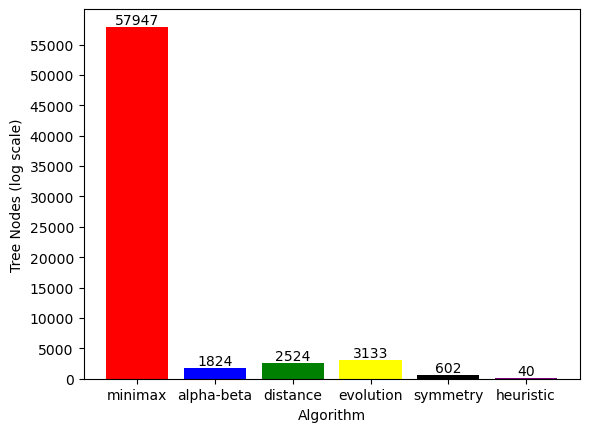

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data
labels2 = ['minimax', 'alpha-beta', 'distance', 'evolution', 'symmetry', 'heuristic']
print(labels)
print(alpha)
print(distance)
print(evo)
print(sym)
print(red)
numbers = np.array([np.mean(labels), np.mean(alpha), np.mean(distance), np.mean(evo), np.mean(sym), np.mean(red)])

# Create a bar chart with a logarithmic y-axis
plt.bar(labels2, numbers, color=['red', 'blue', 'green', 'yellow', 'black', 'purple'])
plt.yticks(np.arange(0, max(numbers) + 1, step=5000))
for i, value in enumerate(numbers):
    plt.text(i, value, f'{value:.0f}', ha='center', va='bottom')
# Add labels and title
plt.xlabel('Algorithm')
plt.ylabel('Tree Nodes (log scale)')

# Show the plot
plt.show()